<a href="https://colab.research.google.com/github/chiconasa3000/learn_nlp/blob/main/arch_transformers_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
!pip install bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 12.6 MB/s eta 0:00:00


In [3]:
from transformers import AutoTokenizer
from transformers import AutoModel
import torch

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)
text = "time flies like an arrow"

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

In [5]:
from torch import nn
from transformers import AutoConfig

In [6]:
config = AutoConfig.from_pretrained(model_ckpt)
# getting general token embedding from bert
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

In [7]:
# use token_embedding to map ids
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()
# 5 tokens is the sequence length
# [batch, seq_len, hidden_dim]

torch.Size([1, 5, 768])

In [8]:
# [query, key] -> similarity function
# get value
import torch
from math import sqrt

query = key = value = inputs_embeds
dim_k = key.size(-1) #768
# batch multiplication matrix


# TODO: all 20 tokens divided in batches of 4 tokens
# every sequence has 4 tokens
# every sequence gives a weight matrix
# multiply weight matrix with other weight matrix
# keep the relationships between all tokens

# multiply matrix batch with the corresponding matrix batch
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
# attention scores w_ji
print(scores.size())

torch.Size([1, 5, 5])


In [9]:
import torch.nn.functional as F
weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

$x_i' = \sum_{j=1}^{n}(w_{ji}x_{j})$

In [10]:
attn_outputs = torch.bmm(weights,value)
attn_outputs.shape

torch.Size([1, 5, 768])

In [11]:
# summary of attention
def scaled_dot_product_attention(query, key, value):
  dim_k = query.size(-1) #768
  scores = torch.bmm(query,key.transpose(1,2))/ sqrt(dim_k)
  weights = F.softmax(scores, dim=-1)
  return torch.bmm(weights,value)

In [12]:

# definition of one head
class AttentionHead(nn.Module):
  def __init__(self, embed_dim, head_dim):
    super().__init__()
    self.q = nn.Linear(embed_dim, head_dim)
    self.k = nn.Linear(embed_dim, head_dim)
    self.v = nn.Linear(embed_dim, head_dim)

  def forward(self, hidden_state):
    attn_outputs = scaled_dot_product_attention(self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
    return attn_outputs

In [13]:
class MultiHeadAttention(nn.Module):

  # pass base config from model pretrained
  def __init__(self,config):
    super().__init__()
    embed_dim = config.hidden_size
    num_heads = config.num_attention_heads
    head_dim = embed_dim // num_heads

    # every head after applying scaled dot product
    self.heads = nn.ModuleList(
        [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
    )
    self.output_linear = nn.Linear(embed_dim,embed_dim)

  def forward(self, hidden_state):
    x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
    x = self.output_linear(x)
    return x

In [14]:
# testing
# config from Bert
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([1, 5, 768])

In [15]:
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
    self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout(config.hidden_dropout_prob)

  def forward(self,x):
    x = self.linear_1(x)
    x = self.gelu(x)
    x = self.linear_2(x)
    x = self.dropout(x)
    return x

In [16]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 5, 768])

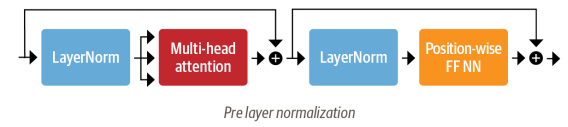

In [17]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
    self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
    self.attention = MultiHeadAttention(config)
    self.feed_forward = FeedForward(config)

  def forward(self,x):
    # apply layer normalization and then copy input into query, key, value
    hidden_state = self.layer_norm_1(x)
    # apply attention with a skip connection
    x = x + self.attention(hidden_state)
    # apply feed_forward layer with a skip conncetion
    x = x + self.feed_forward(self.layer_norm_2(x))
    return x

In [18]:
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

In [19]:
config.max_position_embeddings

512

In [20]:
torch.arange(5,dtype=torch.long)

tensor([0, 1, 2, 3, 4])

In [21]:
torch.arange(5,dtype=torch.long).unsqueeze(0)

tensor([[0, 1, 2, 3, 4]])

In [22]:
config.hidden_size

768

In [27]:
class Embeddings(nn.Module):
  def __init__(self, config):
    super().__init__()
    #[30522,768]
    self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
    #[5,768]
    self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)

    self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
    self.dropout = nn.Dropout()

  def forward(self, input_ids):
    # number of tokens
    seq_length = input_ids.size(1)
    # [0,1,...,4]
    position_ids = torch.arange(seq_length,dtype=torch.long).unsqueeze(0)
    token_embeddings = self.token_embeddings(input_ids)
    position_embeddings = self.position_embeddings(position_ids)

    embeddings = token_embeddings + position_embeddings
    embeddings = self.layer_norm(embeddings)
    embeddings = self.dropout(embeddings)
    return embeddings

embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()



torch.Size([1, 5, 768])

In [28]:
config.num_hidden_layers

12

In [31]:
class TransformerEncoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.embeddings = Embeddings(config)
    self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])

  def forward(self,x):
    x = self.embeddings(x)
    for layer in self.layers:
      x = layer(x)
    return x


In [33]:
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

torch.Size([1, 5, 768])

In [35]:
class TransformerForSequenceClassification(nn.Module):
  def __init__(self,config):
    super().__init__()
    #[b,5,768]
    self.encoder = TransformerEncoder(config)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    #[768,3]
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

  def forward(self,x):
    # first token is hidden state to use to classification [CLS]
    x = self.encoder(x)[:,0,:]
    x = self.dropout(x)
    x = self.classifier(x)
    return x

config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
res_enc = encoder_classifier(inputs.input_ids)
res_enc.size()


torch.Size([1, 3])

In [36]:
# 3 classes to assign a label a entire sequence of 5 tokens
res_enc

tensor([[ 0.9469,  0.3969, -0.5217]], grad_fn=<AddmmBackward0>)